In [2]:
import pandas as pd
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")
print("Dimensions of train: {}".format(train.shape))
print("Dimensions of test: {}".format(test.shape))

Dimensions of train: (891, 12)
Dimensions of test: (418, 11)


# Exploring the data
The files we just opened are available on the data page for the Titanic competition on Kaggle. That page also has a data dictionary, which explains the various columns that make up the data set. Below are the descriptions contained in that data dictionary:

* PassengerID— A column added by Kaggle to identify each row and make submissions easier
* Survived— Whether the passenger survived or not and the value we are predicting (0=No, 1=Yes)
* Pclass— The class of the ticket the passenger purchased (1=1st, 2=2nd, 3=3rd)
* Sex— The passenger’s sex
* Age— The passenger’s age in years
* SibSp— The number of siblings or spouses the passenger had aboard the Titanic
* Parch— The number of parents or children the passenger had aboard the Titanic
* Ticket— The passenger’s ticket number
* Fare— The fare the passenger paid
* Cabin— The passenger’s cabin number
* Embarked— The port where the passenger embarked (C=Cherbourg, Q=Queenstown, S=Southampton)
The data page on Kaggle has some additional notes about some of the columns. It’s always worth exploring this in detail to get a full understanding of the data.

Let’s take a look at the first few rows of the train dataframe.

In [3]:
train.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

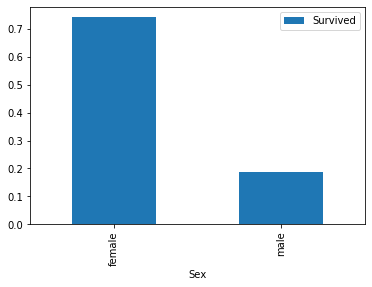

In [4]:
import matplotlib.pyplot as plt

sex_pivot = train.pivot_table(index="Sex",values="Survived")
sex_pivot.plot.bar()
plt.show()

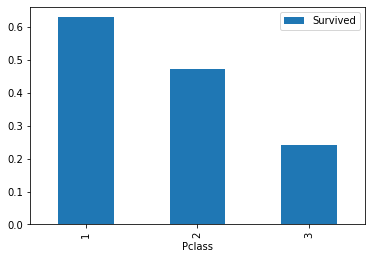

In [5]:
class_pivot = train.pivot_table(index="Pclass",values="Survived")
class_pivot.plot.bar()
plt.show()

# Exploring and converting the age column
The Sex and PClass columns are what we call categorical features. That means that the values represented a few separate options (for instance, whether the passenger was male or female).

Let’s take a look at the Age column using Series.describe().

In [6]:
train["Age"].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

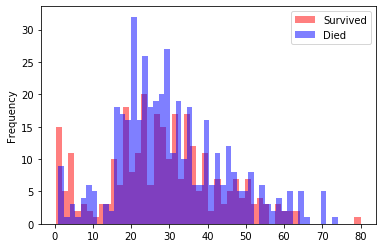

In [7]:
survived = train[train["Survived"] == 1]
died = train[train["Survived"] == 0]
survived["Age"].plot.hist(alpha=0.5,color='red',bins=50)
died["Age"].plot.hist(alpha=0.5,color='blue',bins=50)
plt.legend(['Survived','Died'])
plt.show()

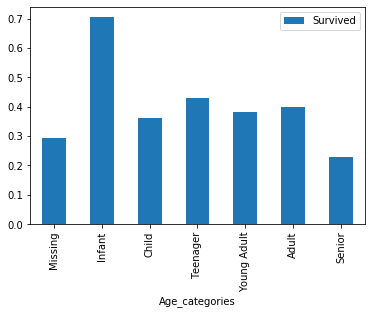

In [8]:
def process_age(df,cut_points,label_names):
    df["Age"] = df["Age"].fillna(-0.5)
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

cut_points = [-1,0,5,12,18,35,60,100]
label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
train = process_age(train,cut_points,label_names)
test = process_age(test,cut_points,label_names)

pivot = train.pivot_table(index="Age_categories",values='Survived')
pivot.plot.bar()
plt.show()

# Preparing our data for machine learning
So far we have identified three columns that may be useful for predicting survival:

1. Sex
2. Pclass
3. Age, or more specifically our newly created Age_categories

Before we build our model, we need to prepare these columns for machine learning. Most machine learning algorithms can’t understand text labels, so we have to convert our values into numbers.

Additionally, we need to be careful that we don’t imply any numeric relationship where there isn’t one. The data dictionary tells us that the values in the Pclass columnare 1, 2, and 3. We can confirm this with pandas:

In [9]:
train["Pclass"].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [11]:
def create_dummies(df,column_name):
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

for column in ["Pclass","Sex","Age_categories"]:
    train = create_dummies(train,column)
    test = create_dummies(test,column)


# Creating our first machine learning model
Now that our data has been prepared, we are ready to train our first model. The first model we will use is called Logistic Regression, which is often the first model you will train when performing classification.

We will be using the scikit-learn library as it has many tools that make performing machine learning easier. The scikit-learn workflow consists of four main steps:

* Instantiate (or create) the specific machine learning model you want to use
* Fit the model to the training data
* Use the model to make predictions
* Evaluate the accuracy of the predictions
* Each model in scikit-learn is implemented as a separate class and the first step is to identify the class we want to create an instance of. In our case, we want to use the LogisticRegression class.

We’ll start by looking at the first two steps. First, we need to import the class:

In [12]:
from sklearn.linear_model import LogisticRegression

In [13]:
lr = LogisticRegression()

In [14]:
columns = ['Pclass_2', 'Pclass_3', 'Sex_male']
lr.fit(train[columns], train['Survived'])

c:\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [15]:
from sklearn.linear_model import LogisticRegression

columns = ['Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Age_categories_Missing','Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
      'Age_categories_Senior']

lr = LogisticRegression()
lr.fit(train[columns], train["Survived"])

c:\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [16]:
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
                   solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

# Splitting our training data

In [17]:
holdout = test # from now on we will refer to this
               # dataframe as the holdout data

from sklearn.model_selection import train_test_split

all_X = train[columns]
all_y = train['Survived']

train_X, test_X, train_y, test_y = train_test_split(
    all_X, all_y, test_size=0.20,random_state=0)

In [18]:
lr = LogisticRegression()
lr.fit(train_X, train_y)
predictions = lr.predict(test_X)

c:\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [19]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(test_y, predictions)

In [20]:
from sklearn.metrics import accuracy_score
lr = LogisticRegression()
lr.fit(train_X, train_y)
predictions = lr.predict(test_X)
accuracy = accuracy_score(test_y, predictions)
print(accuracy)

0.8100558659217877


c:\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [21]:
cross_val_score(estimator, X, y, cv=None)

NameError: name 'cross_val_score' is not defined

In [22]:
from sklearn.model_selection import cross_val_score

lr = LogisticRegression()
scores = cross_val_score(lr, all_X, all_y, cv=10)
scores.sort()
accuracy = scores.mean()

print(scores)
print(accuracy)

[0.76404494 0.76404494 0.7752809  0.8        0.80681818 0.80898876
 0.80898876 0.81111111 0.83146067 0.87640449]
0.8047142776075361


c:\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\python37\lib\site-packages\sklea

# Making predictions on unseen data

In [23]:
lr = LogisticRegression()
lr.fit(all_X,all_y)
holdout_predictions = lr.predict(holdout[columns])

c:\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


# Creating a submission file

In [25]:
holdout_ids = holdout["PassengerId"]
submission_df = {"PassengerId": holdout_ids,
                 "Survived": holdout_predictions}
submission = pd.DataFrame(submission_df)

In [26]:
submission.to_csv("submissionn.csv",index=False)